In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
dataset = pd.read_csv("./MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
feature_list = dataset.columns.values

In [5]:
dataset.shape  
dataset = dataset.replace(np.inf,np.nan)    # replacing inf with nan
dataset = dataset.fillna(dataset.mean(numeric_only=True)) # ghen converting nan to mean values

In [6]:
X = dataset.iloc[:,:-1].values
print("shape of X",X.shape)

Y = dataset.iloc[:,-1].values
print("shape of Y",Y.shape)

shape of X (225745, 78)
shape of Y (225745,)


In [7]:
print("is NaN present:",np.any(np.isnan(X)))  # to check whether the array contains nan
print("is inf present:",np.any(np.isinf(X)))  # to check whether the array contains inf
X[X < 0] = 0   # to replace all negative values with zeros

is NaN present: False
is inf present: False


In [8]:
from sklearn.feature_selection import SelectKBest  # feature selection
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif

In [9]:
bestfeatures = SelectKBest(score_func = mutual_info_classif, k=50)
fit = bestfeatures.fit(X,Y)
#create df for scores
dfscores = pd.DataFrame(fit.scores_)
#create df for column names
dfcolumns = pd.DataFrame(feature_list)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)

#naming the dataframe columns
featureScores.columns = ['Selected_columns','Score_chi2']  
#print 50 best features
print(featureScores.nlargest(50,'Score_chi2')) 


                Selected_columns  Score_chi2
4    Total Length of Fwd Packets    0.652068
63             Subflow Fwd Bytes    0.651940
52           Average Packet Size    0.564119
65             Subflow Bwd Bytes    0.549076
5    Total Length of Bwd Packets    0.548190
12        Bwd Packet Length Mean    0.544841
54          Avg Bwd Segment Size    0.544588
55           Fwd Header Length.1    0.544414
34             Fwd Header Length    0.543802
0               Destination Port    0.538324
10         Bwd Packet Length Max    0.529123
66        Init_Win_bytes_forward    0.497992
53          Avg Fwd Segment Size    0.489662
8         Fwd Packet Length Mean    0.489627
6          Fwd Packet Length Max    0.486305
35             Bwd Header Length    0.474918
23                   Fwd IAT Max    0.460907
20                 Fwd IAT Total    0.457202
21                  Fwd IAT Mean    0.447666
2              Total Fwd Packets    0.411365
62           Subflow Fwd Packets    0.409349
22        

In [10]:
# print(featureScores.nlargest(50,'Score_chi2').Selected_columns.values)
featureScore_after_filter = featureScores.nlargest(50,'Score_chi2')
print(featureScore_after_filter.index[0])
count = 0
ind = []
for i in featureScore_after_filter.Score_chi2:
    if i < 0.2:
        ind.append(featureScore_after_filter.index[count])
    count = count + 1
featureScore_after_filter = featureScore_after_filter.drop(ind,axis = 0)  # contains all the filtered features
X = pd.DataFrame(X)
X = X.loc[:,featureScore_after_filter.index] # contains data after filter from feature selection
print(X)

4
          4     63   52   65   5    12   54    55    34       0   ...  \
0       12.0  12.0  9.0  0.0  0.0  0.0  0.0  40.0  40.0  54865.0  ...   
1        6.0   6.0  9.0  6.0  6.0  6.0  6.0  20.0  20.0  55054.0  ...   
2        6.0   6.0  9.0  6.0  6.0  6.0  6.0  20.0  20.0  55055.0  ...   
3        6.0   6.0  9.0  6.0  6.0  6.0  6.0  20.0  20.0  46236.0  ...   
4       12.0  12.0  9.0  0.0  0.0  0.0  0.0  40.0  40.0  54863.0  ...   
...      ...   ...  ...  ...  ...  ...  ...   ...   ...      ...  ...   
225740   6.0   6.0  9.0  6.0  6.0  6.0  6.0  20.0  20.0  61374.0  ...   
225741   6.0   6.0  9.0  6.0  6.0  6.0  6.0  20.0  20.0  61378.0  ...   
225742   6.0   6.0  9.0  6.0  6.0  6.0  6.0  20.0  20.0  61375.0  ...   
225743  12.0  12.0  9.0  0.0  0.0  0.0  0.0  40.0  40.0  61323.0  ...   
225744   6.0   6.0  9.0  6.0  6.0  6.0  6.0  20.0  20.0  61326.0  ...   

                   36   39     1             14   11     18   17  \
0       666666.666700  6.0    3.0  4.000000e+06  0.0 

In [11]:
from sklearn.model_selection import train_test_split  
x_train, x_test, y_train, y_test= train_test_split(X, Y, test_size= 0.2, random_state=0)

In [12]:
from sklearn.preprocessing import StandardScaler  # scaling of the data

scaler_X = StandardScaler()
x_train_scaled = scaler_X.fit_transform(x_train) # preprocessed training data
x_test_scaled = scaler_X.fit_transform(x_test) # preprocessed testing data

In [13]:
from sklearn.neighbors import KNeighborsClassifier  
classifier= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 )  
classifier.fit(x_train, y_train)  

KNeighborsClassifier()

In [14]:
y_pred= classifier.predict(x_test)  

In [15]:
# confusion matrix
from sklearn.metrics import confusion_matrix  
cm= confusion_matrix(y_test, y_pred)  
print(cm)

[[19419    70]
 [   43 25617]]


<AxesSubplot:>

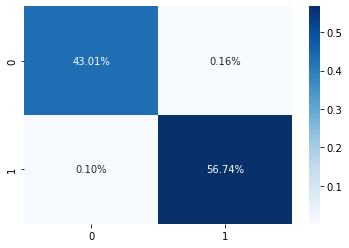

In [16]:
# heatmap of confusion matrix
import seaborn as sns
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

In [17]:
# accuracy of the model
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)
# print("The accuracy of the model is:",accuracy_score(y_test, y_pred)*100,"%")

0.9974971760171876